# Exploring Dandiset 001174: Calcium imaging in SMA and M1 of macaques

**⚠️ DISCLAIMER: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results. ⚠️**

This notebook provides an exploration of Dandiset 001174 (version 0.250331.2218), which contains one-photon calcium imaging data from the supplementary motor area (SMA) and primary motor (M1) areas in rhesus macaques.

Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218

## Overview

This Dandiset contains calcium imaging data recorded from non-human primates (rhesus macaques) during rest or while engaged in an arm reaching task. The researchers used gradient index lenses and expressed GCaMP6f to image calcium transients in neurons within the supplementary motor (SMA) and primary motor (M1) areas.

In this notebook, we will:
1. Load a Dandiset and explore its metadata
2. Access and visualize raw calcium imaging data from an NWB file
3. Examine ROI (region of interest) masks that identify individual neurons
4. Analyze fluorescence traces and detected calcium events
5. Explore the relationship between fluorescence signals and event detections

## Required Packages

This notebook requires the following Python packages:
- pynwb: For working with NWB files
- h5py: For handling HDF5 data structures
- remfile: For accessing remote NWB files
- numpy: For numerical operations
- pandas: For data manipulation
- matplotlib: For plotting
- seaborn: For improved plot aesthetics
- scipy: For scientific computing functions
- dandi: For accessing the DANDI archive

Note: Loading remote NWB files may take significant time depending on your internet connection and the file size. The files in this Dandiset are quite large, so please be patient during the loading process.

### Understanding Calcium Imaging

Before we dive into the data, let's briefly explain how calcium imaging works:

1. **Calcium Indicators**: Neurons in this study express GCaMP6f, a genetically encoded calcium indicator that fluoresces when bound to calcium. 

2. **Neural Activity & Calcium**: When neurons fire action potentials, calcium flows into the cell, causing the GCaMP6f to fluoresce more brightly.

3. **Fluorescence Signal**: The microscope captures this fluorescence, with brighter signals indicating more neural activity.

4. **ROIs & Traces**: Regions of Interest (ROIs) identify individual neurons, and their fluorescence over time creates traces that correspond to neural activity patterns.

5. **Event Detection**: Sudden increases in fluorescence (calcium transients) are detected as "events" and typically correspond to action potentials or bursts of neural activity.

The calcium signal is an indirect measure of neural activity with slower dynamics than electrophysiology, but it allows for simultaneous monitoring of many identified neurons.

In [1]:
# Import required packages
import pynwb
import h5py
import remfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.ndimage import zoom
import seaborn as sns

# Set plot style
sns.set_theme()

## Loading the Dandiset

In [2]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174", "0.250331.2218")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Description: {metadata['description'][:300]}...")

# List some assets in the Dandiset
assets = dandiset.get_assets()
print("\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset URL: https://dandiarchive.org/dandiset/001174/0.250331.2218
Description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution. We ...

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb (ID: a2b04c7f-f671-4a55-ac36-5df4d842dfc2)
- sub-Q/sub-Q_ophys.nwb (ID: de07db56-e7f3-4809-9972-755c51598e8d)
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (ID: ac161d0e-7642-48bd-9bef-8eff59319d48)
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (ID: 9c3678d5-22c3-402c-8cd4-6bc38c4d61e3)
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (ID: b4e6bbf7-0564-4628-b8f0-680fd9b8d4ea)


## Exploring an NWB File

Let's load one of the NWB files from the Dandiset. We'll choose a relatively small file to work with, specifically "sub-Q/sub-Q_ophys.nwb", which contains calcium imaging data from the supplementary motor area (SMA) during the spontaneous condition.

Note: Loading remote NWB files may take some time depending on your internet connection speed and the file size.

In [3]:
# Define the asset ID for the file we'll examine
asset_id = "de07db56-e7f3-4809-9972-755c51598e8d"
file_path = "sub-Q/sub-Q_ophys.nwb"

# Create a URL for accessing the file
url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
print(f"Accessing NWB file: {file_path}")
print(f"URL: {url}")

# Open the NWB file using remfile for remote access
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Print basic file information
print("\nNWB File Information:")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject age: {nwb.subject.age}")

Accessing NWB file: sub-Q/sub-Q_ophys.nwb
URL: https://api.dandiarchive.org/api/assets/de07db56-e7f3-4809-9972-755c51598e8d/download/



NWB File Information:
Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2022-09-15 13:16:33.129000+00:00
Subject ID: Q
Subject species: Macaca mulatta
Subject sex: F
Subject age: P5Y


### Additional Metadata

Let's extract some more metadata about the experimental conditions:

In [4]:
# Print experiment metadata
print("Experiment Details:")
print(f"Session ID: {nwb.identifier}")
print(f"Timestamps reference time: {nwb.timestamps_reference_time}")
print(f"File creation date: {nwb.file_create_date}")
print(f"Keywords: {metadata.get('keywords', 'Not provided')}")

# Display contributor information if available
if 'contributor' in metadata:
    print(f"Number of contributors: {len(metadata['contributor'])}")
    print(f"First few contributors: {', '.join(metadata['contributor'][:5]) if isinstance(metadata['contributor'][0], str) else 'Complex contributor data structure'}")

# Print information about the imaging device
devices = nwb.devices
for name, device in devices.items():
    print(f"\nDevice: {name}")
    print(f"Description: {device.description}")
    print(f"Manufacturer: {device.manufacturer}")

Experiment Details:
Session ID: 5c2c4bb2-8310-4e0e-ae01-fd872edba928
Timestamps reference time: 2022-09-15 13:16:33.129000+00:00
File creation date: [datetime.datetime(2025, 1, 23, 15, 39, 28, 539904, tzinfo=tzutc())]
Keywords: ['One-photon calcium imaging, non-human primates, microendoscope, reaching task, neuronal coactivation, calcium sensors, GCaMP, GRIN lens']
Number of contributors: 11
First few contributors: Complex contributor data structure

Device: Miniscope
Description: NVista3
Manufacturer: Inscopix, Inc.


### Neurosift Link

You can explore this NWB file in more detail using Neurosift, an online NWB file viewer:

[View this file in Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/de07db56-e7f3-4809-9972-755c51598e8d/download/&dandisetId=001174&dandisetVersion=0.250331.2218)

## Understanding the NWB File Structure

Let's examine the structure of the NWB file to understand what data is available for analysis.

In [5]:
# Print information about the acquisition data
print("Acquisition Data:")
for name, data_interface in nwb.acquisition.items():
    print(f"\n  {name} ({type(data_interface).__name__}):")
    print(f"  - Description: {data_interface.description}")
    if hasattr(data_interface, 'data'):
        print(f"  - Data shape: {data_interface.data.shape}")
        print(f"  - Data type: {data_interface.data.dtype}")
    if hasattr(data_interface, 'rate'):
        print(f"  - Sampling rate: {data_interface.rate} Hz")

# Print information about the processing data
print("\nProcessing Modules:")
for module_name, module in nwb.processing.items():
    print(f"\n  {module_name} module ({type(module).__name__}):")
    print(f"  - Description: {module.description}")
    
    for interface_name, interface in module.data_interfaces.items():
        print(f"\n    {interface_name} ({type(interface).__name__}):")
        
        if hasattr(interface, 'roi_response_series'):
            for series_name, series in interface.roi_response_series.items():
                print(f"      - {series_name} shape: {series.data.shape}, rate: {series.rate} Hz")
                
        elif hasattr(interface, 'plane_segmentations'):
            for seg_name, seg in interface.plane_segmentations.items():
                print(f"      - {seg_name} with {len(seg.id)} ROIs")
                
        elif hasattr(interface, 'data'):
            print(f"      - Data shape: {interface.data.shape}, rate: {interface.rate if hasattr(interface, 'rate') else 'N/A'} Hz")

Acquisition Data:

  OnePhotonSeries (OnePhotonSeries):
  - Description: Miniscope imaging data
  - Data shape: (6041, 320, 200)
  - Data type: uint16
  - Sampling rate: 10.01 Hz

Processing Modules:

  ophys module (ProcessingModule):
  - Description: Optical physiology data obtained by processing raw calcium imaging data

    EventAmplitude (RoiResponseSeries):
      - Data shape: (6041, 40), rate: 10.013668242678232 Hz

    Fluorescence (Fluorescence):
      - RoiResponseSeries shape: (6041, 40), rate: 10.01 Hz

    ImageSegmentation (ImageSegmentation):
      - PlaneSegmentation with 40 ROIs


Based on the structure above, we can see that this NWB file contains:

1. **OnePhotonSeries**: Raw calcium imaging data with dimensions (frames, height, width)
2. **ImageSegmentation**: Contains ROI masks for identified cells
3. **Fluorescence**: Contains fluorescence traces for each ROI
4. **EventAmplitude**: Contains detected calcium events for each ROI

Let's explore each of these components in detail.

## Visualizing Raw Calcium Imaging Data

First, let's look at a sample frame from the raw imaging data to understand what the calcium imaging data looks like.

OnePhotonSeries shape: (6041, 320, 200)
Number of frames: 6041
Frame dimensions: 320 x 200
Sampling rate: 10.01 Hz
Total recording time: 603.50 seconds


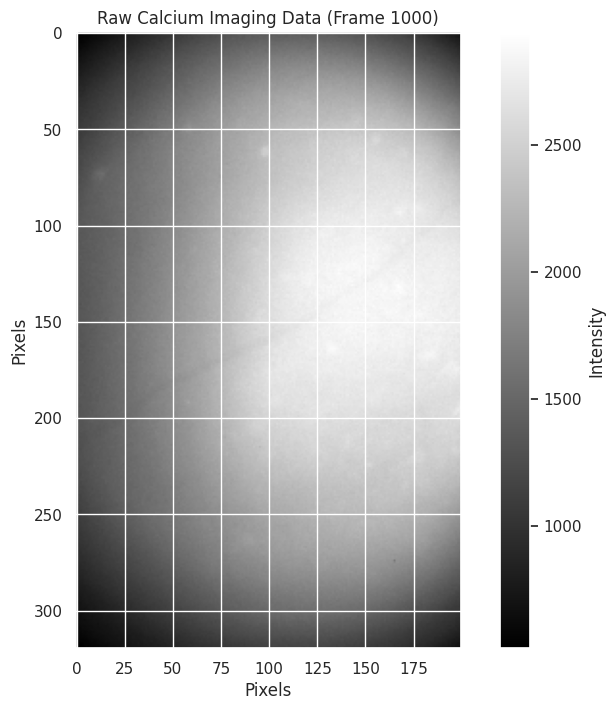

In [6]:
# Access the OnePhotonSeries data
one_photon_series = nwb.acquisition['OnePhotonSeries']

# Print information about the imaging data
print(f"OnePhotonSeries shape: {one_photon_series.data.shape}")
print(f"Number of frames: {one_photon_series.data.shape[0]}")
print(f"Frame dimensions: {one_photon_series.data.shape[1]} x {one_photon_series.data.shape[2]}")
print(f"Sampling rate: {one_photon_series.rate} Hz")
print(f"Total recording time: {one_photon_series.data.shape[0] / one_photon_series.rate:.2f} seconds")

# Select a frame from the middle of the recording
frame_idx = 1000
sample_frame = one_photon_series.data[frame_idx, :, :]

# Plot the sample frame
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.colorbar(label='Intensity')
plt.title(f'Raw Calcium Imaging Data (Frame {frame_idx})')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.show()

The image above shows a single frame from the calcium imaging data. The brighter areas in the image potentially correspond to active neurons or other fluorescent structures in the field of view. The gradient from darker to lighter areas across the image is typical of one-photon calcium imaging and represents variations in illumination and tissue depth.

One-photon calcium imaging typically has a lower spatial resolution and higher background fluorescence compared to two-photon imaging, which is why we see this gradient effect across the field of view.

## Exploring ROI Masks

Next, let's examine the ROI (Region of Interest) masks that identify individual neurons in the calcium imaging data. The ROIs represent the spatial locations of individual neurons that have been identified through segmentation algorithms.

In [7]:
# Access the ROI masks from the PlaneSegmentation
ophys = nwb.processing['ophys']
image_segmentation = ophys.data_interfaces['ImageSegmentation']
plane_seg = image_segmentation.plane_segmentations['PlaneSegmentation']

# Print information about the ROI masks
num_rois = len(plane_seg.id)
print(f"Number of ROIs: {num_rois}")
print(f"ROI column names: {plane_seg.colnames}")

# Get information about the first ROI mask
first_mask = plane_seg['image_mask'][0]
print(f"Shape of first ROI mask: {first_mask.shape}")

Number of ROIs: 40
ROI column names: ('image_mask',)


Shape of first ROI mask: (292, 179)


The ROI masks need to be resized to match the imaging data dimensions before visualization.
Let's create a function to do this:

In [8]:
# Function to resize masks to match the imaging data dimensions
def resize_mask(mask, target_shape):
    """
    Resize an ROI mask to match the target shape using scipy's zoom function.
    
    Parameters:
    -----------
    mask : numpy.ndarray
        The ROI mask to resize
    target_shape : tuple
        The target shape (height, width)
        
    Returns:
    --------
    numpy.ndarray
        The resized mask
    """
    # Calculate zoom factors
    zoom_y = target_shape[0] / mask.shape[0]
    zoom_x = target_shape[1] / mask.shape[1]
    
    # Resize the mask using scipy's zoom function
    return zoom(mask, (zoom_y, zoom_x), order=0)

Now, let's visualize a few individual ROI masks overlaid on the sample frame:

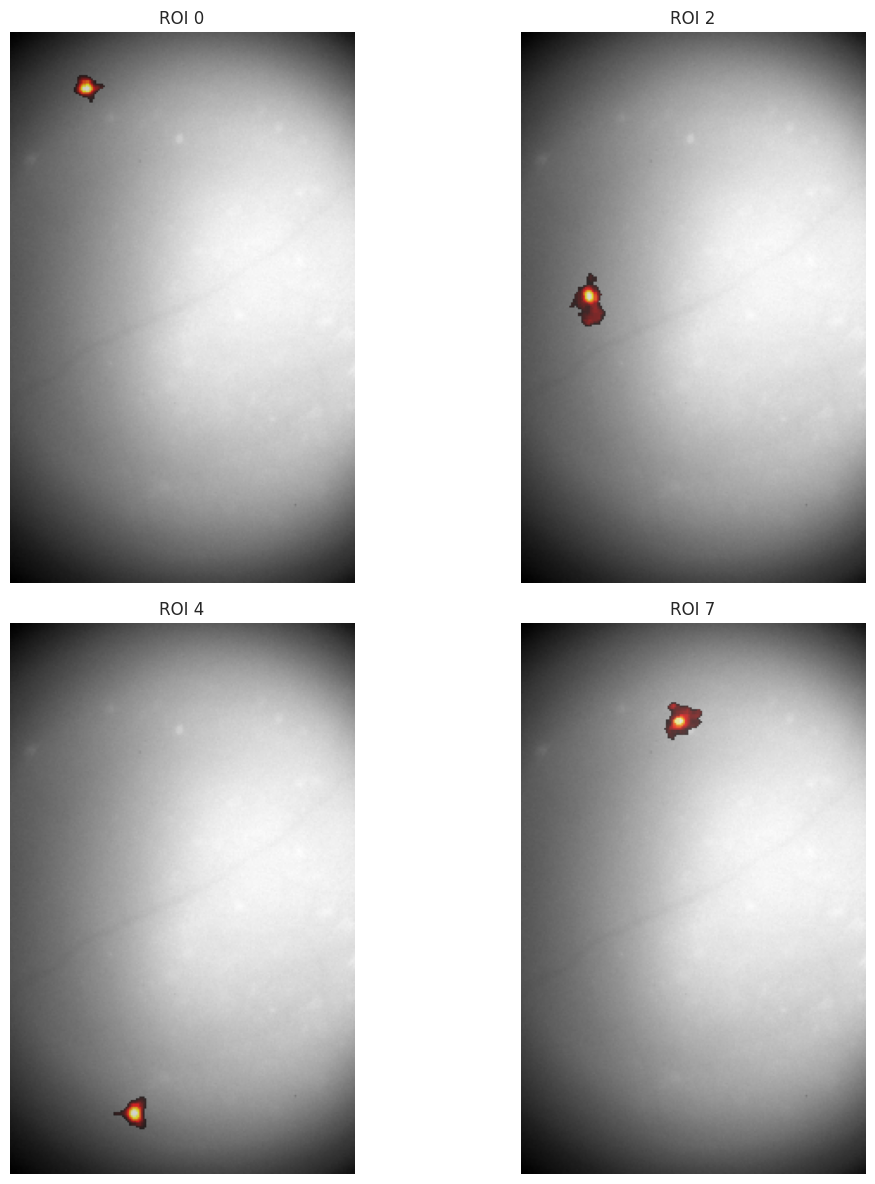

In [9]:
# Select a few ROIs to visualize
roi_indices = [0, 2, 4, 7]
roi_ids = plane_seg.id.data[roi_indices]

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, roi_idx in enumerate(roi_indices):
    # Get the mask and resize it
    mask = plane_seg['image_mask'][roi_idx]
    resized_mask = resize_mask(mask, sample_frame.shape)
    
    # Create a masked array for overlay
    mask_overlay = np.ma.masked_where(resized_mask == 0, resized_mask)
    
    # Plot the sample frame with the ROI overlay
    axes[i].imshow(sample_frame, cmap='gray')
    axes[i].imshow(mask_overlay, cmap='hot', alpha=0.7)
    axes[i].set_title(f'ROI {roi_ids[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The visualizations above show individual ROIs overlaid on the sample frame. Each ROI represents a distinct neuron or cellular structure identified in the calcium imaging data. The masks have varying intensities from 0 to 1, where higher values (brighter colors) indicate greater confidence in the detection of the cellular structure at that location.

Now, let's create a visualization with all ROIs overlaid on the same image to see their spatial distribution:

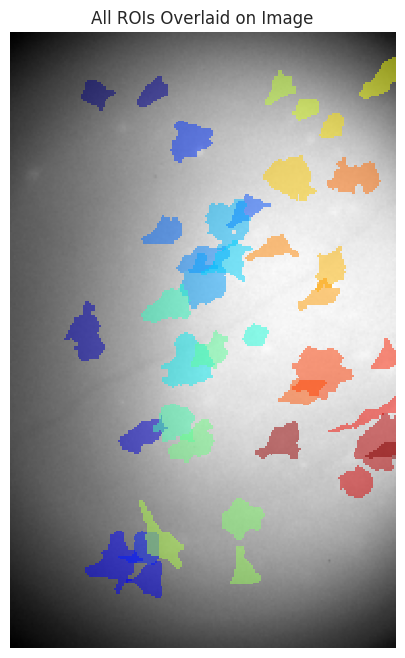

In [10]:
# Create a combined visualization with all ROIs
plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')

# Create a colormap for the ROIs
colors = plt.cm.jet(np.linspace(0, 1, len(plane_seg.id)))

# Overlay all ROI masks with transparency and different colors
for i in range(len(plane_seg.id)):
    mask = plane_seg['image_mask'][i]
    resized_mask = resize_mask(mask, sample_frame.shape)
    
    # Create a masked array for this ROI
    masked_data = np.ma.masked_where(resized_mask == 0, resized_mask)
    
    # Plot with the color from our colormap
    plt.imshow(masked_data, cmap=ListedColormap([colors[i]]), alpha=0.5, interpolation='none')

plt.title('All ROIs Overlaid on Image')
plt.axis('off')
plt.show()

This visualization shows all ROIs overlaid on the sample frame, with each ROI assigned a different color. We can see that the ROIs are distributed throughout the field of view, with some clustering in certain regions. Each colored area represents a distinct neuron or cellular structure that was identified during the image segmentation process.

The color coding helps distinguish different ROIs, which is particularly important in areas where multiple neurons might be close together. The spatial distribution of these ROIs can provide insights into the cellular organization of the supplementary motor area being imaged.

Finally, let's create a heatmap visualization that shows all ROIs with their intensity values:

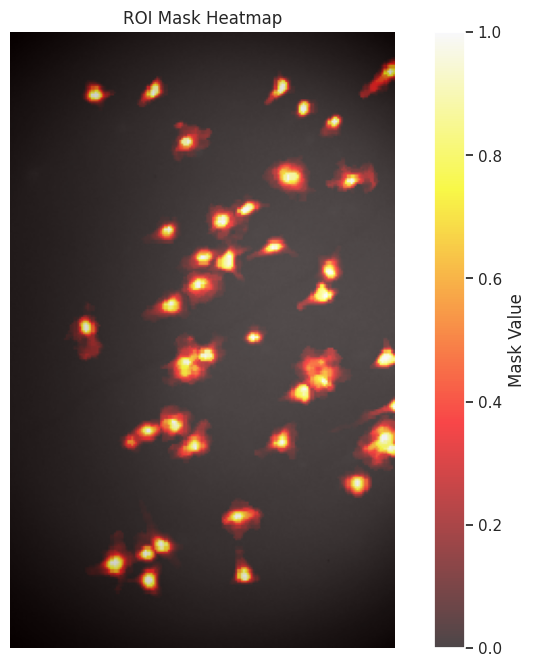

In [11]:
# Create a heatmap-style visualization of all ROIs
combined_mask = np.zeros_like(sample_frame, dtype=float)

for i in range(len(plane_seg.id)):
    mask = plane_seg['image_mask'][i]
    resized_mask = resize_mask(mask, sample_frame.shape)
    combined_mask = np.maximum(combined_mask, resized_mask)

plt.figure(figsize=(10, 8))
plt.imshow(sample_frame, cmap='gray')
plt.imshow(combined_mask, cmap='hot', alpha=0.7)
plt.title('ROI Mask Heatmap')
plt.colorbar(label='Mask Value')
plt.axis('off')
plt.show()

The heatmap visualization shows the intensity values of all ROI masks combined. Brighter colors (yellow/white) indicate higher intensity values, which typically correspond to stronger confidence in the detection of neuronal structures. The gradient from red to yellow/white in the masks demonstrates the varying levels of confidence in the ROI segmentation, with the cores of neurons typically showing the highest values.

## Analyzing Fluorescence Traces

Now that we understand the spatial organization of the ROIs, let's examine their fluorescence traces over time. These traces represent the calcium activity of individual neurons during the recording.

In [12]:
# Access the fluorescence data
fluorescence = ophys.data_interfaces['Fluorescence']
roi_response_series = fluorescence.roi_response_series['RoiResponseSeries']

# Print information about the fluorescence data
print(f"Fluorescence data shape: {roi_response_series.data.shape}")
print(f"Number of time points: {roi_response_series.data.shape[0]}")
print(f"Number of ROIs: {roi_response_series.data.shape[1]}")
print(f"Sampling rate: {roi_response_series.rate} Hz")
print(f"Total recording time: {roi_response_series.data.shape[0] / roi_response_series.rate:.2f} seconds")

# Create a time vector
time_vector = np.arange(roi_response_series.data.shape[0]) / roi_response_series.rate

Fluorescence data shape: (6041, 40)
Number of time points: 6041
Number of ROIs: 40
Sampling rate: 10.01 Hz
Total recording time: 603.50 seconds


Let's plot the fluorescence traces for a few selected ROIs:

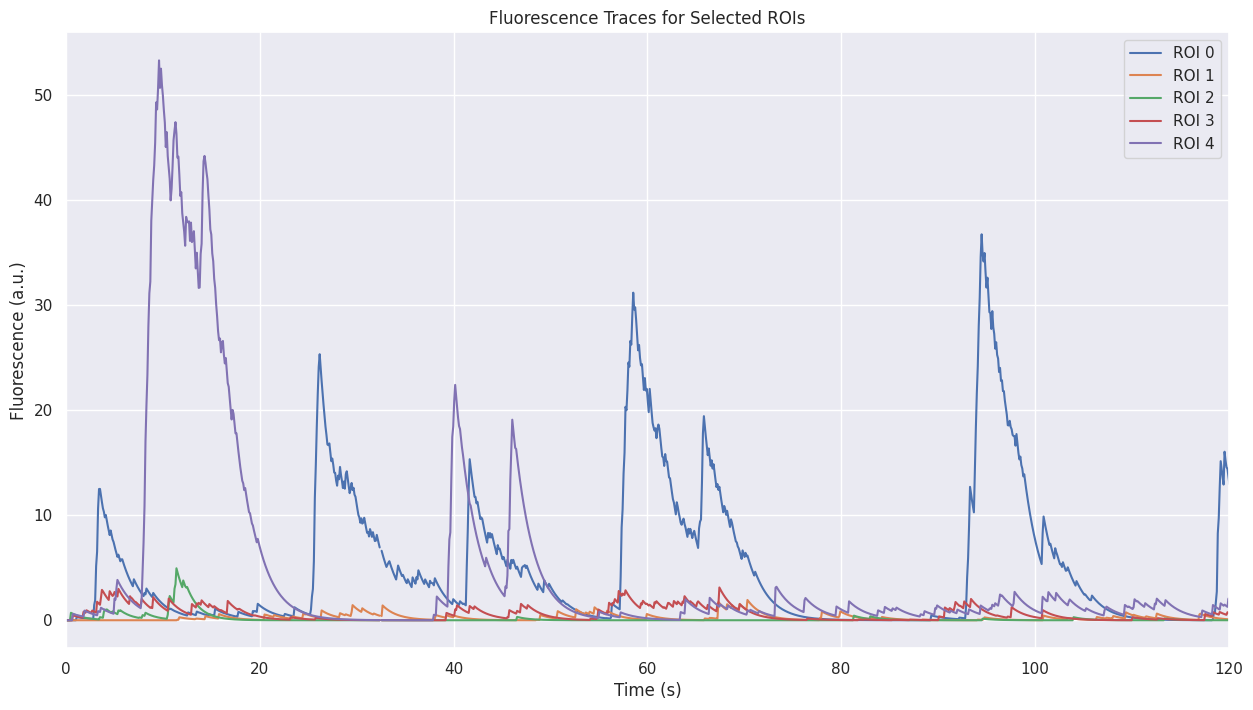

In [13]:
# Select a subset of ROIs to visualize
selected_roi_indices = np.arange(5)  # First 5 ROIs
selected_roi_ids = plane_seg.id.data[selected_roi_indices]
selected_traces = roi_response_series.data[:, selected_roi_indices]

plt.figure(figsize=(15, 8))
for i, roi_idx in enumerate(selected_roi_indices):
    plt.plot(time_vector, selected_traces[:, i], label=f'ROI {selected_roi_ids[i]}')

plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title('Fluorescence Traces for Selected ROIs')
plt.legend()
plt.grid(True)
plt.xlim(0, 120)  # Plot first 2 minutes for clarity
plt.show()

The fluorescence traces above show the calcium activity of five different ROIs over time. Each trace represents the fluorescence intensity of a single ROI, with higher values indicating increased calcium concentration, which correlates with neural activity.

We can observe several interesting patterns:

1. **Distinct activity patterns**: Different ROIs show different patterns of activity, with some being more active than others.
2. **Calcium transients**: The sharp increases in fluorescence represent calcium influx events, typically associated with action potentials or bursts of neural activity.
3. **Fast rise, slow decay**: The calcium signals show characteristic fast rise times followed by slower decay, which reflects the underlying calcium dynamics in neurons.
4. **Varying amplitudes**: The amplitude of calcium events varies across ROIs and within the same ROI over time, potentially reflecting differences in firing rates or patterns.

Let's now look at the full trace for a single ROI that shows interesting activity:

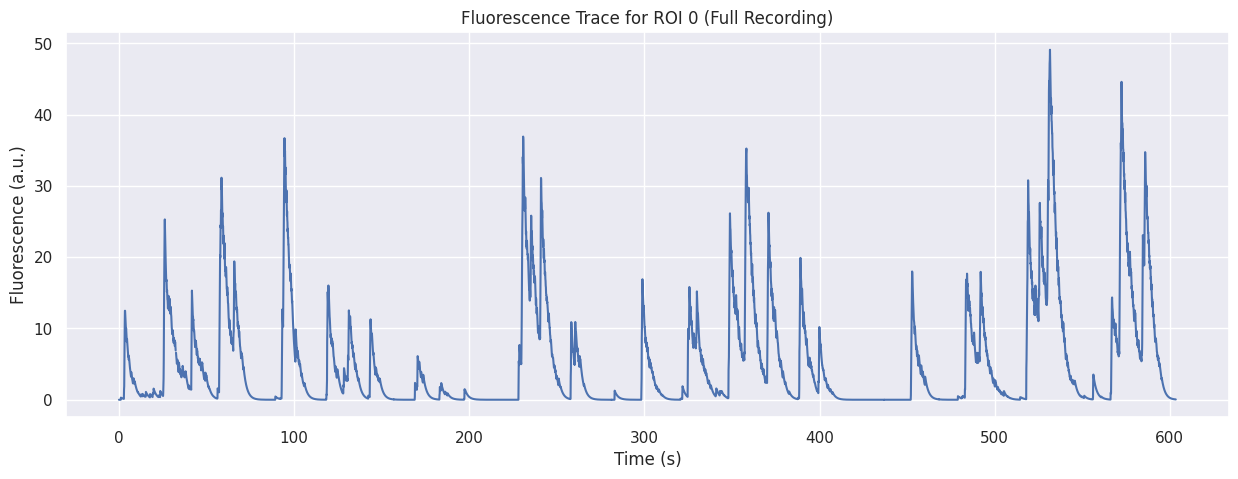

In [14]:
# Select an ROI with interesting activity (based on previous plot)
roi_idx = 0  # We observed this ROI had clear calcium events
roi_id = plane_seg.id.data[roi_idx]
full_trace = roi_response_series.data[:, roi_idx]

plt.figure(figsize=(15, 5))
plt.plot(time_vector, full_trace)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence (a.u.)')
plt.title(f'Fluorescence Trace for ROI {roi_id} (Full Recording)')
plt.grid(True)
plt.show()

The trace above shows the fluorescence signal over time for a single ROI across the entire recording session. This gives us a better understanding of the long-term activity patterns of this neuron. We can observe:

1. **Episodic activity**: The neuron shows distinct periods of activity (with calcium transients) interspersed with periods of relative quiescence.
2. **Burst-like patterns**: Some events appear clustered together, potentially representing bursts of action potentials.
3. **Amplitude variations**: The peak heights vary throughout the recording, suggesting variations in the intensity of neural activity.
4. **Low baseline**: Between events, the fluorescence returns to a relatively stable baseline, indicating the absence of calcium influx during these periods.

These patterns are typical for neurons in motor areas, which often show task-related or spontaneous activity bursts followed by periods of lower activity.

## Analyzing Calcium Events

The NWB file also contains information about detected calcium events, which have been extracted from the fluorescence traces using specialized algorithms. These events represent significant calcium influx likely associated with neuronal firing. Let's compare the fluorescence trace with the event amplitude data for one ROI:

Event amplitude data shape: (6041, 40)
Number of time points: 6041
Number of ROIs: 40
Sampling rate: 10.013668242678232 Hz


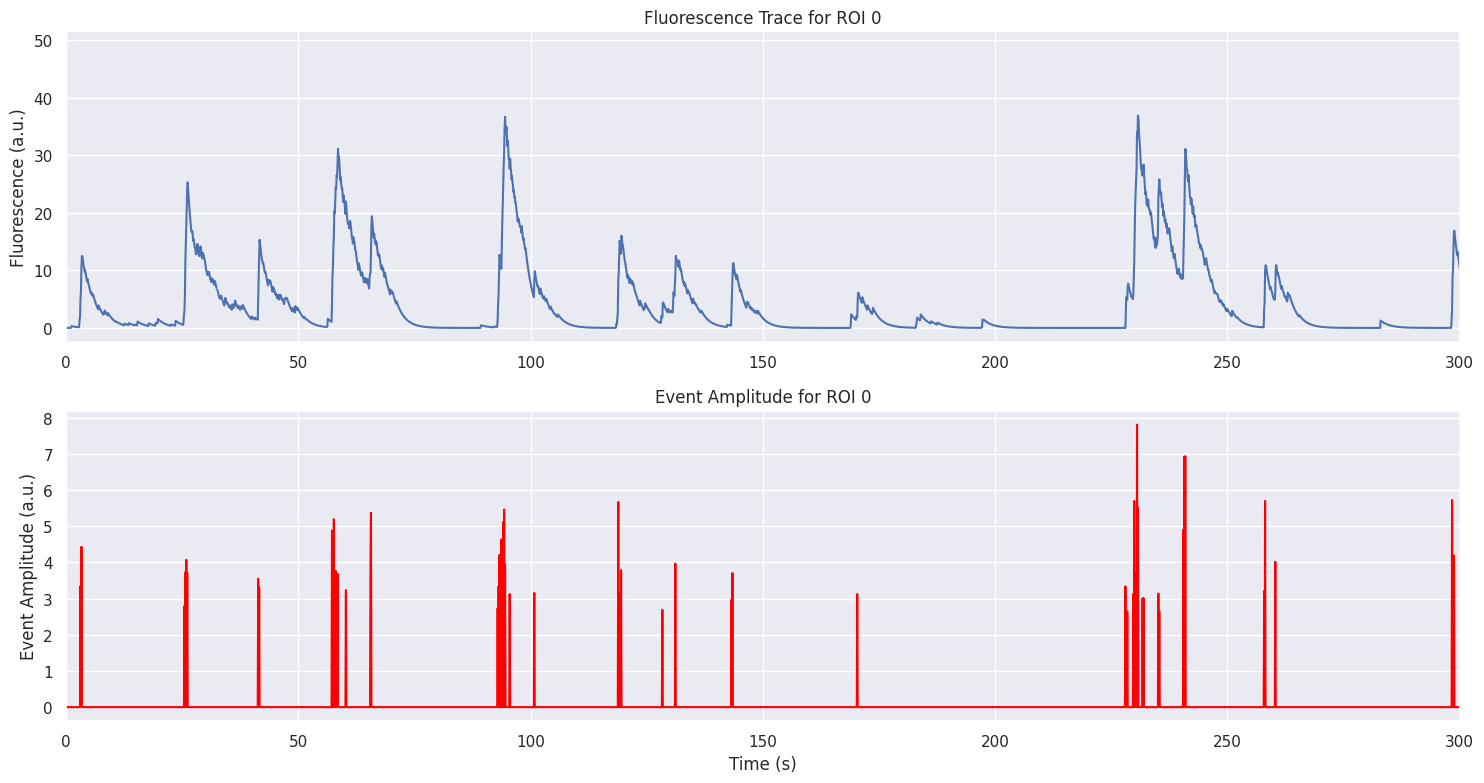

In [15]:
# Access the event amplitude data
event_amplitude = ophys.data_interfaces['EventAmplitude']

# Print information about the event amplitude data
print(f"Event amplitude data shape: {event_amplitude.data.shape}")
print(f"Number of time points: {event_amplitude.data.shape[0]}")
print(f"Number of ROIs: {event_amplitude.data.shape[1]}")
print(f"Sampling rate: {event_amplitude.rate} Hz")

# Plot the fluorescence trace and event amplitude for one ROI
roi_idx = 0  # Same ROI as above
roi_id = plane_seg.id.data[roi_idx]

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(time_vector, roi_response_series.data[:, roi_idx])
plt.title(f'Fluorescence Trace for ROI {roi_id}')
plt.ylabel('Fluorescence (a.u.)')
plt.grid(True)
plt.xlim(0, 300)  # First 5 minutes for clarity

plt.subplot(2, 1, 2)
plt.plot(time_vector, event_amplitude.data[:, roi_idx], color='red')
plt.title(f'Event Amplitude for ROI {roi_id}')
plt.xlabel('Time (s)')
plt.ylabel('Event Amplitude (a.u.)')
plt.grid(True)
plt.xlim(0, 300)  # First 5 minutes for clarity

plt.tight_layout()
plt.show()

The comparison above shows how the event amplitude data (bottom) corresponds to the fluorescence trace (top). The event amplitude data is non-zero only when there is a significant calcium event detected in the fluorescence trace.

The event detection algorithm identifies calcium transients in the fluorescence trace and quantifies their amplitude. This process helps distinguish true calcium events from noise and baseline fluctuations. The amplitude of each event provides information about the magnitude of the underlying neural activity, with larger amplitudes potentially indicating stronger or more synchronized neural firing.

Let's now look at a smaller segment of the data to see the relationship between the fluorescence trace and detected events in more detail:

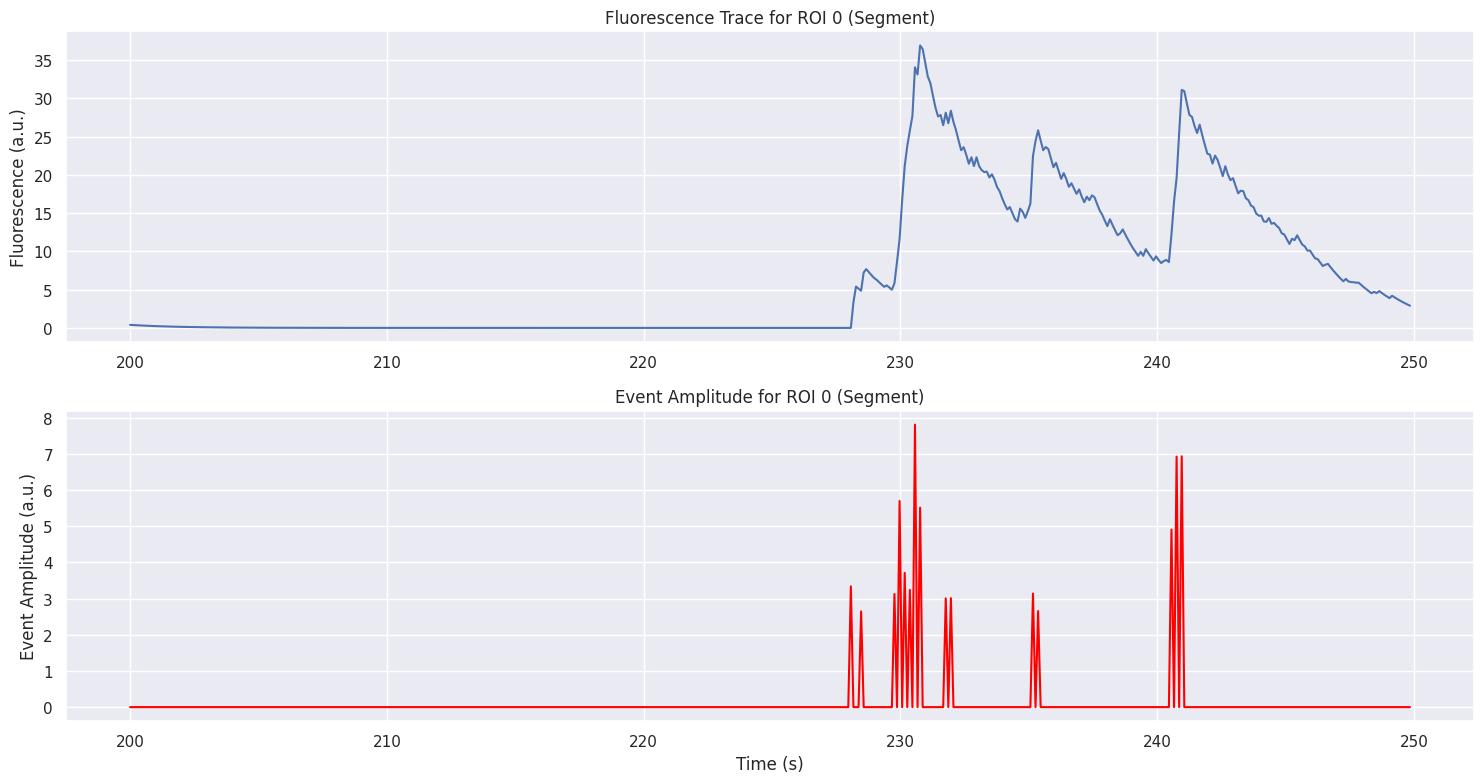

In [16]:
# Select a segment of the data where there are clear events
segment_start = 200  # Start time in seconds
segment_duration = 50  # Duration in seconds

# Convert to indices
start_idx = int(segment_start * roi_response_series.rate)
end_idx = int((segment_start + segment_duration) * roi_response_series.rate)

# Extract the segment data
segment_time = time_vector[start_idx:end_idx]
segment_fluo = roi_response_series.data[start_idx:end_idx, roi_idx]
segment_events = event_amplitude.data[start_idx:end_idx, roi_idx]

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(segment_time, segment_fluo)
plt.title(f'Fluorescence Trace for ROI {roi_id} (Segment)')
plt.ylabel('Fluorescence (a.u.)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(segment_time, segment_events, color='red')
plt.title(f'Event Amplitude for ROI {roi_id} (Segment)')
plt.xlabel('Time (s)')
plt.ylabel('Event Amplitude (a.u.)')
plt.grid(True)

plt.tight_layout()
plt.show()

This zoomed-in view allows us to see the precise relationship between calcium transients in the fluorescence trace and the corresponding detected events. We can observe:

1. **Temporal alignment**: Events are detected at the onset of rapid increases in fluorescence.
2. **Amplitude correspondence**: Larger fluorescence transients generally result in higher event amplitudes.
3. **Event duration**: While the fluorescence signal takes time to decay back to baseline, the event detection captures the moment of calcium influx.
4. **Threshold-based detection**: Not all small fluctuations in the fluorescence trace result in detected events, suggesting a threshold-based detection algorithm.

This detailed view demonstrates how the event detection algorithm effectively identifies significant calcium transients while ignoring minor fluctuations, providing a cleaner representation of neuronal firing patterns.

## Correlations Between ROIs

Finally, let's analyze correlations between different ROIs to see if there are patterns of coordinated activity, which might indicate functional connections or shared inputs among neurons:

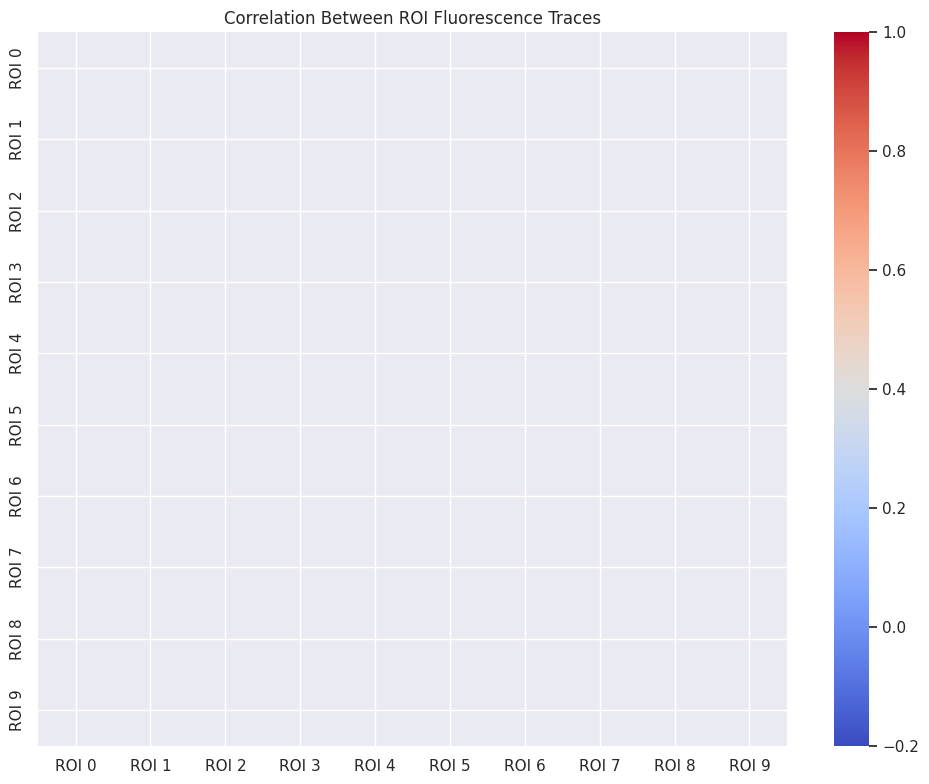

In [17]:
# Select a subset of ROIs for correlation analysis
num_rois_to_analyze = 10
roi_indices = np.arange(num_rois_to_analyze)
roi_ids = plane_seg.id.data[roi_indices]

# Extract fluorescence data for these ROIs
roi_traces = roi_response_series.data[:, roi_indices]

# Calculate correlation matrix
correlation_matrix = np.corrcoef(roi_traces.T)

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=[f"ROI {id}" for id in roi_ids],
            yticklabels=[f"ROI {id}" for id in roi_ids],
            vmin=-0.2, vmax=1.0, annot_kws={"size": 8})
plt.title('Correlation Between ROI Fluorescence Traces')
plt.tight_layout()
plt.show()

The correlation matrix visualized as a heatmap shows the pairwise correlations between the fluorescence traces of different ROIs. Each cell represents the Pearson correlation coefficient between two ROIs, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation).

Interpreting the correlation matrix:

1. **Diagonal elements**: These are always 1, as each ROI is perfectly correlated with itself.
2. **Positive correlations (red)**: Indicate that two ROIs tend to be active at the same time, suggesting potential functional connectivity or shared inputs.
3. **Negative correlations (blue)**: Suggest that when one ROI is active, the other tends to be less active, potentially indicating inhibitory relationships.
4. **Near-zero correlations (white)**: Indicate that the activity patterns of the two ROIs are largely independent.

The presence of correlated activity between certain ROI pairs could reflect various neurobiological phenomena:
- Neurons that are part of the same functional circuit
- Neurons that respond to the same stimuli or behavioral events
- Neurons that receive common inputs from other brain regions
- Neurons that are physically connected via synapses

This kind of correlation analysis is often a first step in understanding the functional organization of neural populations.

## Summary and Future Directions

In this notebook, we've explored Dandiset 001174, which contains one-photon calcium imaging data from the supplementary motor area (SMA) and primary motor (M1) areas in rhesus macaques. We've learned how to:

1. Load a Dandiset using the DANDI API
2. Access and examine an NWB file containing calcium imaging data
3. Visualize raw imaging data and ROI masks
4. Analyze fluorescence traces and detected calcium events
5. Investigate correlations between ROIs

This analysis provides insights into the neural activity patterns in the motor areas of non-human primates. The calcium imaging data reveals dynamic patterns of activity across different neurons, with some showing more frequent or stronger calcium events than others.

### Potential Future Analyses

There are many additional analyses that could be performed with this dataset, including:

1. **Event Frequency Analysis**: Calculate the frequency of calcium events for each ROI over time
2. **Population Dynamics**: Analyze how groups of neurons activate together using dimensionality reduction techniques like PCA or t-SNE
3. **Cross-Session Comparisons**: Compare neural activity patterns across different recording sessions
4. **Task-Related Activity**: For sessions that included arm reaching tasks, analyze how neural activity relates to task performance
5. **Spatial Clustering**: Investigate whether neurons with similar activity patterns are spatially clustered
6. **Temporal Structure**: Analyze the temporal dynamics of neuronal activity patterns using time-series analysis methods
7. **Network Analysis**: Construct functional networks based on correlations and analyze their properties

### Computational Considerations

When working with calcium imaging datasets, especially large ones, keep in mind:

1. **Memory Usage**: Loading large datasets entirely into memory may not be feasible; consider using chunking or streaming approaches
2. **Computational Efficiency**: Many operations (e.g., correlation calculations) scale with the number of ROIs and time points
3. **Remote Access**: Working with remote files can be slower; consider downloading files for intensive analyses
4. **Processing Pipeline**: Different preprocessing steps can affect results; be aware of how the data was processed

## References

- DANDI Archive: https://dandiarchive.org/
- Dandiset 001174: https://dandiarchive.org/dandiset/001174/0.250331.2218
- PyNWB Documentation: https://pynwb.readthedocs.io/
- Calcium Imaging Analysis: Chen et al. (2013). Ultrasensitive fluorescent proteins for imaging neuronal activity. Nature, 499(7458), 295–300.